# Moving in 2D

In [1]:
abstract type AbstractWalker end

In [2]:
abstract type AbstractWalker2D <: AbstractWalker end

In [3]:
struct Location
    x::Int
    y::Int
end

In [4]:
mutable struct Walker2D <: AbstractWalker2D
    position::Location
end

In [5]:
methods(Walker2D)

# 2 methods for type constructor:
[1] Walker2D(position::Location) in Main at In[4]:2
[2] Walker2D(position) in Main at In[4]:2

In [6]:
Walker2D(x,y) = Walker2D(Location(x, y)) # constructor for Walker2D

Walker2D

In [7]:
walker = Walker2D(0, 0) # Initialising a walker at origin

Walker2D(Location(0, 0))

In [8]:
walker.position

Location(0, 0)

In [9]:
function make_tuple(a::Location)
    return (a.x, a.y)
end

make_tuple (generic function with 1 method)

In [10]:
pos(w::Walker2D) = w.position

pos (generic function with 1 method)

In [11]:
function set_pos!(w::Walker2D, l::Location)
    w.position = l
end

set_pos! (generic function with 1 method)

In [12]:
function jump(w::Walker2D)
    l = pos(w)
    x, y = make_tuple(l)
    #neighbours = ((x,y+1), (x,y-1), (x+1,y), (x-1,y))
    a, b = rand(((x,y+1), (x,y-1), (x+1,y), (x-1,y)))
    return Location(a, b)
end

jump (generic function with 1 method)

In [13]:
pos(walker)

Location(0, 0)

In [14]:
jump(walker)

Location(1, 0)

In [15]:
set_pos!(walker, Location(21, 43))

Location(21, 43)

In [16]:
pos(walker)

Location(21, 43)

In [17]:
jump(walker)

Location(21, 42)

In [18]:
function jump!(w::Walker2D)
    set_pos!(w, jump(w))
end

jump! (generic function with 1 method)

In [19]:
k = jump!(walker)

Location(20, 43)

In [20]:
typeof(k)

Location

In [21]:
pos(walker)

Location(20, 43)

In [22]:
function trajectory(w::Walker2D, N)
    traj = [make_tuple(jump!(w)) for i in 1:N]
    return traj
end

trajectory (generic function with 1 method)

In [23]:
trajectory(walker, 10)

10-element Vector{Tuple{Int64, Int64}}:
 (19, 43)
 (19, 42)
 (18, 42)
 (18, 41)
 (17, 41)
 (16, 41)
 (16, 42)
 (17, 42)
 (17, 41)
 (17, 42)

In [24]:
using Plots

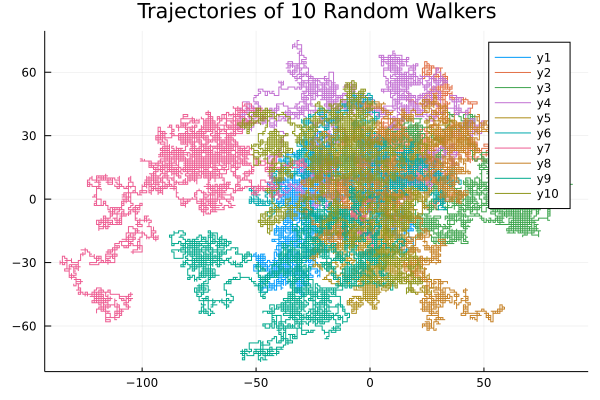

In [25]:
p = plot(title="Trajectories of 10 Random Walkers")

for i in 1:10
    w = Walker2D(0, 0)
    plot!(trajectory(w, 10_000))
end

p

# Making agents move

In [26]:
@enum InfectionStatus S I R

In [27]:
x = R
typeof(x)

Enum InfectionStatus:
S = 0
I = 1
R = 2

In [28]:
mutable struct Agent <: AbstractWalker2D
    position::Location
    state::InfectionStatus
end

Agents live in a box of side length L, centered at the origin. We need to decide (i.e. model) what happens when they reach the walls of the box (boundaries), i.e. what kind of boundary conditions to use.

One type of boundary condition that is relatively simple to implement are reflecting boundary conditions, as follows:

Each side of the box is a reflective mirror. We can model this using "bounce-back": if the particle tries to jump beyond one of the boundaries, it hits a springy wall and bounces back to the same position that it started from. That is, it proposes to take a step, but "realises" that it is blocked in that direction, so just stays where it is instead for that step.

In [29]:
Agent(x, y, z) = Agent(Location(x, y), z)

Agent

In [30]:
new_wa = Agent(0, 0, R)

Agent(Location(0, 0), R)

In [31]:
new_wa.position

Location(0, 0)

In [32]:
pos(w::Agent) = w.position

pos (generic function with 2 methods)

In [33]:
function set_pos!(w::Agent, l::Location)
    w.position = l
end

set_pos! (generic function with 2 methods)

In [34]:
function jump(w::Agent)
    l = pos(w)
    x, y = make_tuple(l)
    #neighbours = ((x,y+1), (x,y-1), (x+1,y), (x-1,y))
    a, b = rand(((x,y+1), (x,y-1), (x+1,y), (x-1,y)))
    return (a, b)
end

jump (generic function with 2 methods)

In [35]:
function jump!(w::Agent, L) # L is the length of each side of the grid which bounds the walkers
    x, y = jump(w)
    
    if ((-L/2) < x < (L/2)) && ((-L/2) < y < (L/2))
        set_pos!(w, Location(x, y))
        return x, y
    else
        x, y = make_tuple(pos(w))
        return x, y
    end
end

jump! (generic function with 2 methods)

Now we check that the boundary condition is working by drawing a trajectory of an Agent inside a square box of side length 20, using the function trajectory from previous part

In [36]:
function trajectory(w::Agent, N, L)
    traj = [(jump!(w, L)) for i in 1:N]
    return traj
end

trajectory (generic function with 2 methods)

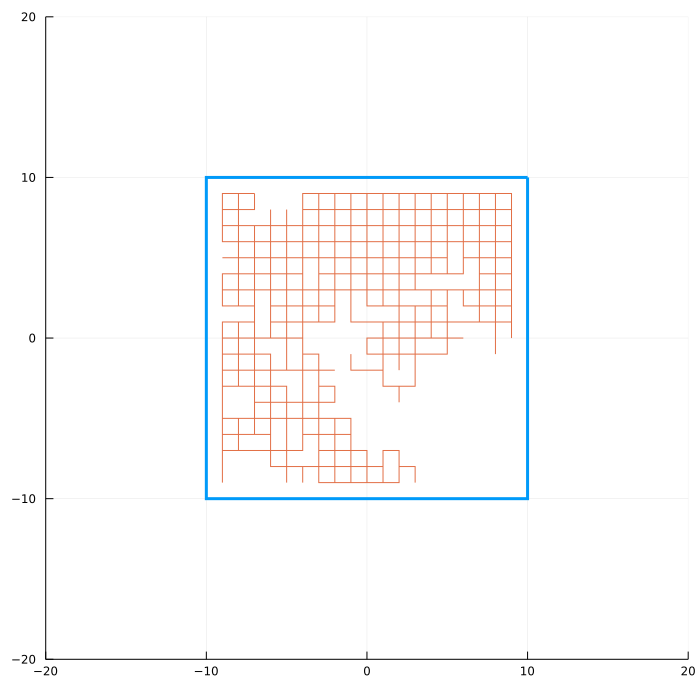

In [37]:
L = 20

# we draw a closed loop by passing a vector of tuples of vertices abcda
plot([(L/2, L/2), (L/2, -L/2), (-L/2, -L/2), (-L/2, L/2), (L/2, L/2)], xlim=(-L, L), ylim=(-L, L), lw=3, ratio=1, leg=false, size=(700, 700))

w = Agent(0, 0, S)
plot!(trajectory(w, 2000, 20))

# Spatial epidemic model -- Initialization and visualization

We now have all of the technology in place to simulate an agent-based model in space!

For simplicity we will impose in the model that there is at most one agent on each site at all times, modelling the fact that two people cannot be in the same place as each other.

We thus begin by creating an initial condition for $N$ agents that satisfies this. Later we must make sure that the dynamics also respects this.

The function $initialize$ takes parameters $L$, the side length of the square box where the agents live, and $N$, the number of agents.

It should build, one by one, a collection of agents, by proposing a position for each one and checking if that position is occupied. If the position is occupied, it should generate another one, and so on until it finds a free spot.

You may create additional functions to help with this if you find it useful to do so.

The agents should all have initial status S, except for one of them, e.g. the first in the list, which has initial status I -- i.e. it is the only source of infection.

It should return the Vector of Agents.

In [38]:
function initialize(L, N)
    x = Int(rand((-L/2):(L/2)))
    y = Int(rand((-L/2):(L/2)))
    taken = [(x, y)]
    agents = [Agent(x, y, I)] # Setting the first agent as Infected
    for i in 2:N
        t1,t2 = make_tuple(pos(agents[i-1]))
        while (t1, t2) in taken
            t1 = Int(rand((-L/2):(L/2)))
            t2 = Int(rand((-L/2):(L/2)))
        end
        push!(taken, (t1, t2))
        push!(agents, Agent(t1, t2, S))
    end
    
    return agents, taken
end

initialize (generic function with 1 method)

In [39]:
agents, taken = initialize(10, 20)
taken

20-element Vector{Tuple{Int64, Int64}}:
 (-5, 2)
 (-4, -5)
 (-1, -1)
 (-2, -5)
 (-5, 0)
 (-3, -4)
 (0, 5)
 (3, 0)
 (1, 3)
 (1, -4)
 (-2, 2)
 (0, -3)
 (-3, 2)
 (3, -5)
 (1, -5)
 (-5, -1)
 (0, -5)
 (-4, -3)
 (-2, -2)
 (5, 1)

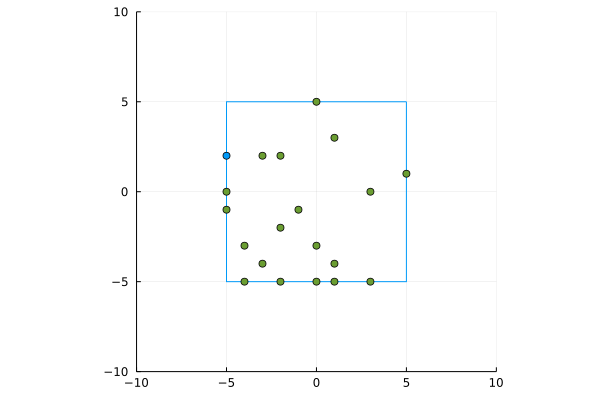

In [40]:
L = 10
cs = [0, 1, 2]
s = scatter(color=cs, ratio=1, xlim=(-L,L), ylim=(-L, L), leg=false)
plot!([(L/2, L/2), (L/2, -L/2), (-L/2, -L/2), (-L/2, L/2), (L/2, L/2)])
for i  in 1:length(agents)
    scatter!(make_tuple(agents[i].position), color=Int(agents[i].state))
end
s

In [41]:
function visualize_agents(agents, L)
    cs = [0, 1, 2] # Different color for different states
    
    s = scatter(color=cs, ratio=1, xlim=(-L,L), ylim=(-L, L), leg=false)
    plot!([(L/2, L/2), (L/2, -L/2), (-L/2, -L/2), (-L/2, L/2), (L/2, L/2)])
    
    for i  in 1:length(agents)
        scatter!(make_tuple(agents[i].position), color=Int(agents[i].state))
    end
    
    return s
end

visualize_agents (generic function with 1 method)

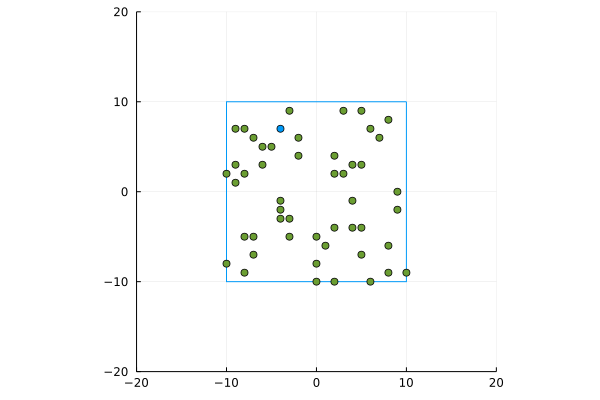

In [42]:
L = 20
N = 50
agents, _ = initialize(L, N)
visualize_agents(agents, L)

# Spatial epidemic model -- Dynamics

function step! does one step of the dynamics of the model. It takes as parameters $L$, $p_I$ and $p_R$. This combines what we did in the last Problem Set with the 2D random walker above.

The rules are as follows:

- A single agent is chosen at random; call it agent $i$.

- A new position is proposed for that agent.

- If that new position is not occupied, the agent moves there.

- If the new position is occupied, by agent $j$, then neither of them move, but they interact via the following rule:

- If agent $i$ is infected and agent $j$ is susceptible then agent $j$ becomes infected with probability $p_I$.

- If agent $i$ is infected, it recovers with probability $p_R$.



In [43]:
function step!(agents::Vector{Agent}, taken, L, p_I, p_R)
    n = length(agents)
    i = rand(1:n)
    x = Int(rand((-L/2):(L/2)))
    y = Int(rand((-L/2):(L/2)))
    
    if (x, y) in taken
        j_vec = findall(a -> a == (x, y), taken)
        j = j_vec[1]
        
        if agents[i].state == I
            if agents[j].state == S
                agents[j].state = rand() <= p_I ? I : S
            end
            agents[i].state = rand() <= p_R ? R : I
        end
    else
        agents[i].position = Location(x, y)
        taken[i] = (x, y)
    end
    return
end

step! (generic function with 1 method)

In [44]:
L = 10
N = 20
agents, taken = initialize(L, N)

(Agent[Agent(Location(-3, 0), I), Agent(Location(0, 2), S), Agent(Location(3, 3), S), Agent(Location(-3, -4), S), Agent(Location(-5, -5), S), Agent(Location(2, 0), S), Agent(Location(0, 0), S), Agent(Location(4, -2), S), Agent(Location(-3, 1), S), Agent(Location(-2, 5), S), Agent(Location(-5, -3), S), Agent(Location(4, 0), S), Agent(Location(0, -1), S), Agent(Location(-1, -1), S), Agent(Location(5, 2), S), Agent(Location(3, 4), S), Agent(Location(2, 4), S), Agent(Location(-2, 3), S), Agent(Location(2, -1), S), Agent(Location(-3, -2), S)], [(-3, 0), (0, 2), (3, 3), (-3, -4), (-5, -5), (2, 0), (0, 0), (4, -2), (-3, 1), (-2, 5), (-5, -3), (4, 0), (0, -1), (-1, -1), (5, 2), (3, 4), (2, 4), (-2, 3), (2, -1), (-3, -2)])

In [45]:
taken

20-element Vector{Tuple{Int64, Int64}}:
 (-3, 0)
 (0, 2)
 (3, 3)
 (-3, -4)
 (-5, -5)
 (2, 0)
 (0, 0)
 (4, -2)
 (-3, 1)
 (-2, 5)
 (-5, -3)
 (4, 0)
 (0, -1)
 (-1, -1)
 (5, 2)
 (3, 4)
 (2, 4)
 (-2, 3)
 (2, -1)
 (-3, -2)

In [46]:
p_I = 0.7
p_R = 0.3
for i in 1:500
    step!(agents, taken, L, p_I, p_R)
end

agents

20-element Vector{Agent}:
 Agent(Location(0, 3), R)
 Agent(Location(-3, -2), S)
 Agent(Location(-2, -1), S)
 Agent(Location(0, 4), S)
 Agent(Location(5, 3), S)
 Agent(Location(5, 4), R)
 Agent(Location(-5, 2), S)
 Agent(Location(5, -2), S)
 Agent(Location(0, -3), S)
 Agent(Location(-1, -1), R)
 Agent(Location(-3, -1), S)
 Agent(Location(1, -4), S)
 Agent(Location(-4, -5), S)
 Agent(Location(-1, -2), S)
 Agent(Location(2, -4), S)
 Agent(Location(-3, 1), R)
 Agent(Location(3, 2), S)
 Agent(Location(4, -3), S)
 Agent(Location(4, -4), R)
 Agent(Location(3, -2), S)

In [47]:
using Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-330761396478991796\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-15221058847789259975\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-330761396478991796\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [48]:
L = 10
N = 20
agents, taken = initialize(L, N)
p_I = 0.8
p_R = 0.01

0.01

In [49]:
@manipulate for i in 1:500
    step!(agents, taken, L, p_I, p_R)
    visualize_agents(agents, L)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 500, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
250, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\Abhishek Bhatt\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\Abhishek Bhatt\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\Abhishek Bhatt\\.julia\\packages\\InteractBase\\Zfu5P\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\Abhishek Bhatt\\.julia\\packages\\InteractBase\\Zfu5P\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\Abhishek Bhatt\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000050233080, Task (runnable) @0x0000000050233080), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"

In [50]:
function sweep!(agents, taken, L, p_I, p_R)
    n = length(agents)
    [step!(agents, taken, L, p_I, p_R) for _ in 1:n]
end

sweep! (generic function with 1 method)

In [51]:
function dynamics!(agents, taken, L, p_I, p_R, T)
    system = []
    for i in 1:T
        sweep!(agents, taken, L, p_I, p_R)
        push!(system, deepcopy(agents))
    end
    return system
end

dynamics! (generic function with 1 method)

In [53]:
L = 10
N = 20
agents, taken = initialize(L, N)
p_I = 0.8
p_R = 0.01
T = 50
system = dynamics!(agents, taken, L, p_I, p_R, T)

50-element Vector{Any}:
 Agent[Agent(Location(-1, -5), I), Agent(Location(1, -1), S), Agent(Location(3, 4), S), Agent(Location(5, -4), S), Agent(Location(5, 5), S), Agent(Location(-2, -5), S), Agent(Location(3, -4), S), Agent(Location(-2, 1), S), Agent(Location(-4, 4), S), Agent(Location(4, 5), S), Agent(Location(-3, -1), S), Agent(Location(1, 3), S), Agent(Location(2, 0), S), Agent(Location(-4, 0), S), Agent(Location(0, 4), S), Agent(Location(4, 2), S), Agent(Location(4, 3), S), Agent(Location(3, -1), S), Agent(Location(3, 2), S), Agent(Location(0, -1), S)]
 Agent[Agent(Location(-1, -5), I), Agent(Location(1, -1), S), Agent(Location(3, 4), S), Agent(Location(3, 3), S), Agent(Location(5, 5), S), Agent(Location(-2, -5), S), Agent(Location(-1, 0), S), Agent(Location(2, -4), S), Agent(Location(-4, 4), S), Agent(Location(-2, -2), S), Agent(Location(-3, -1), S), Agent(Location(2, -5), S), Agent(Location(4, -5), S), Agent(Location(-4, 0), S), Agent(Location(0, 4), S), Agent(Location(4, 2), S

In [54]:
system[1][1]

Agent(Location(-1, -5), I)

In [57]:
function plot_in(Ss, Is, Rs)
    p = plot(title="SIR Graph")
    plot!(1:1:length(Ss), Ss, label="S")
    plot!(1:1:length(Is), Is, label="I")
    plot!(1:1:length(Rs), Rs, label="R")
    return p
end

plot_in (generic function with 1 method)

In [59]:
@manipulate for i in 1:T
    p1 = visualize_agents(system[i], L)
    Ss = []
    Is = []
    Rs = []
    for j in 1:i
        s, inf, r = 0, 0, 0
        for k in 1:N
            curr = system[j][k].state
            if curr == S
                s += 1
            elseif curr == I
                inf += 1
            else
                r += 1
            end
        end
        push!(Ss, s)
        push!(Is, inf)
        push!(Rs, r)
    end
    p2 = plot_in(Ss, Is, Rs)
    hbox(p2, p1)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 50, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
25, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\Abhishek Bhatt\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\Abhishek Bhatt\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\Abhishek Bhatt\\.julia\\packages\\InteractBase\\Zfu5P\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\Abhishek Bhatt\\.julia\\packages\\InteractBase\\Zfu5P\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\Abhishek Bhatt\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000000190e0330, Task (runnable) @0x00000000190e0330), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26

In [60]:
L = 20
N = 100
T = 200
@manipulate for p_I in 0.01:0.01:1, p_R in 0.01:0.01:1
    agents, taken = initialize(L, N)
    system = dynamics!(agents, taken, L, p_I, p_R, T)
    Ss = []
    Is = []
    Rs = []
    for j in 1:T
        s, inf, r = 0, 0, 0
        for k in 1:N
            curr = system[j][k].state
            if curr == S
                s += 1
            elseif curr == I
                inf += 1
            else
                r += 1
            end
        end
        push!(Ss, s)
        push!(Is, inf)
        push!(Rs, r)
    end
    plot_in(Ss, Is, Rs)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["p_I"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 100, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
50, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\Abhishek Bhatt\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\Abhishek Bhatt\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\Abhishek Bhatt\\.julia\\packages\\InteractBase\\Zfu5P\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\Abhishek Bhatt\\.julia\\packages\\InteractBase\\Zfu5P\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\Abhishek Bhatt\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000004e5ad140, Task (runnable) @0x000000004e5ad140), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.01\",\"0.02\",\"0.03\",\"0.04\",\"0.05\",\"0.06\",\"0.07\",\"0.08\",\"0.09\",\"0.1\",\"0.11\",\"0.12\",\"0.13\",\"0.14\",\"0.15\",\"0.16\",\"0.17\",\"0.18\",\"0.19\"

**We observe that at p_I = 0.8 and p_R = 0.05, most of the population gets immediately affected, resemblu an outbreak**

Such a model is useful to study the various strategies of combating an epidemic like Covid-19, like social distancing can be introduced in themodel to the difference in the pace of epidemic growth